In [1]:
"""
Optuna example that optimizes a Keras model
"""
import optuna
from optuna.integration.mlflow import MLflowCallback
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import utils, regularizers
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


print(f"TensorFlow {tf.__version__}")
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    

# To disable GPU use
tf.config.set_visible_devices([], 'GPU')
print("Not using GPU !!!")    


NCONSTIT=16
NFEAT=3
NTRIALS = 100
MTR='val_categorical_accuracy'
NEPOCHS = 100
#BSIZES = [32,64,128]  # batch size for Optuna search
BSIZES = [16,32,64]  # batch size for Optuna search
MINLR = 0.0001
MAXLR = 0.0005
MAXNL = 3 # maximum number of layer for Optuna search
MINNEU = 8 # minimum number of neurons per layer for Optuna search
MAXNEU = 128   # maximum number of neurons per layer for Optuna search
PATIEN = 20 # maximum pacience for early stop and checkpoint
REGL1 = 0.0001

# OPTUNA trial syntax
# filters=trial.suggest_categorical("filters", [32, 64]),
# activation=trial.suggest_categorical("activation", ["relu", "linear"]),
# learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
# num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)            
            

def create_model(trial):
    model = Sequential()

    # Define the MLP.
    nlayers = trial.suggest_int("nlayers", 1, MAXNL)
    model = Sequential()
    model.add(Input(shape=(NCONSTIT*NFEAT)))
    for i in range(nlayers):
        nhidden = trial.suggest_int("nhidden_l{}".format(i), MINNEU, MAXNEU, log=True)
        model.add( Dense(nhidden, activation="relu" , kernel_regularizer=regularizers.L1(REGL1), bias_regularizer=regularizers.L1(REGL1) ) )
    model.add( Dense(5, activation="softmax", kernel_regularizer=regularizers.L1(REGL1), bias_regularizer=regularizers.L1(REGL1) ) )

    
    # Define the optimizer
    optim = Adam( learning_rate= trial.suggest_float("learning_rate", MINLR, MAXLR, log=True) )

# compile the model
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
    model.summary()
    return model


def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    
    # early stopping callback
    es = EarlyStopping(monitor=MTR, patience=PATIEN)

    # Learning rate scheduler 
    ls = ReduceLROnPlateau(monitor=MTR, factor=0.8, patience=PATIEN, min_lr=0.00001)


    # model checkpoint callback
    # this saves our model architecture + parameters into bestmodel.h5
    chkp = ModelCheckpoint('bestmodel.h5', monitor=MTR, verbose=0, save_best_only=True, mode='auto', save_freq='epoch')

    pru = optuna.integration.TFKerasPruningCallback(trial, monitor=MTR)


    # Create the model
    model = create_model(trial)

    # Fit the model
    history = model.fit(X_train, Y_train, 
              batch_size= trial.suggest_categorical("bsize", BSIZES),  
              epochs=NEPOCHS, 
              verbose=0,
#              validation_data=(X_val, Y_val),
              validation_split=0.2,
              callbacks=[es,ls,chkp,pru],
              shuffle=True,
              )

    # Load the best saved model
    model = tf.keras.models.load_model( 'bestmodel.h5',)
    
#                                         custom_objects={ "QDense": QDense,"QActivation": QActivation,
#                                                          "QConv1D": QConv1D, "quantized_bits": quantized_bits,
#                                                          "NodeEdgeProjection": NodeEdgeProjection,} )                                        

    # Plot Loss and Accuracy versus Epoch
    
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val loss')
    ax.legend(loc="upper right")
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # Plot training accuracy vs epoch
    ax = plt.subplot(2, 2, 2)
    #ax.plot(history.history['accuracy'], label='accuracy')
    #ax.plot(history.history['val_accuracy'], label='val accuracy')
    ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
    ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
    ax.legend(loc="upper left")
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')

    # Display plots
    fig = plt.gcf()
    plt.show()
#    fig.savefig(fname+'.pdf')
    
    # Evaluate the model on the test data and return accuracy for Optuna optimization
    '''
    score = model.evaluate(X_test, Y_test, verbose=2, return_dict=True, batch_size=1)
    print("Score Keys") 
    score.keys
    tf.print(score)
    return score['categorical_accuracy'] # return the model validation accuracy
    '''
    
    Y_pred = model.predict(X_test)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    accuracy.update_state(Y_test, Y_pred)
    return accuracy.result().numpy()   
    



TensorFlow 2.8.0
Number of available GPUs : 1
Not using GPU !!!



GPU: METAL
Activating procedural GPU memory growth...
kfold numbet of folds: 5
val fold num: 4

----------------
Data loading complete:
File name: None
Training data size: 480,840
Test data size: 120,210
Number of constituents: 16
Number of features: 3
----------------

(480840, 16, 3)
(480840, 48) (120210, 48) (480840, 5) (120210, 5)


[I 2023-11-13 04:57:29,218] A new study created in RDB with name: mlp_study


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 441       
                                                                 
 dense_1 (Dense)             (None, 5)                 50        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


2023-11-13 04:57:29.460667: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


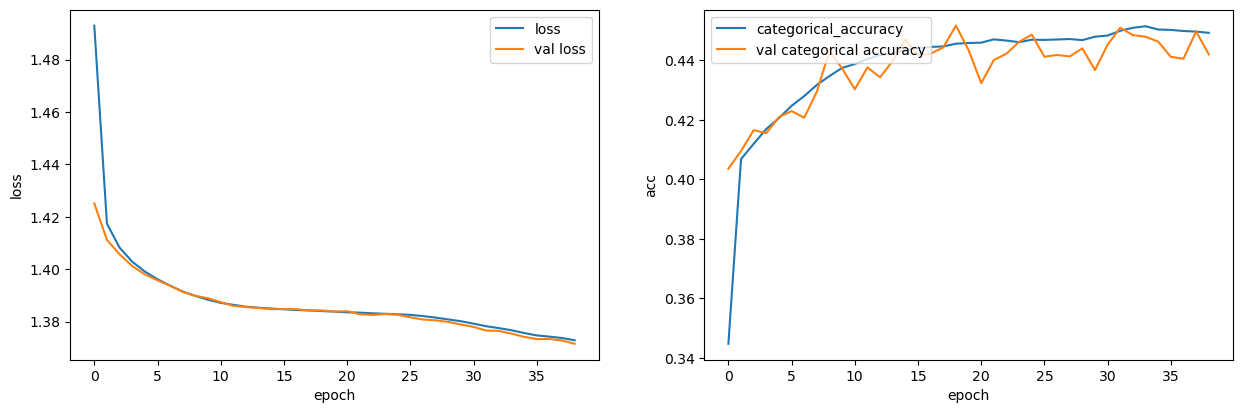

[I 2023-11-13 04:59:53,332] Trial 0 finished with value: 0.4521920084953308 and parameters: {'nlayers': 1, 'nhidden_l0': 9, 'learning_rate': 0.0003984277315177279, 'bsize': 32}. Best is trial 0 with value: 0.4521920084953308.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 27)                1323      
                                                                 
 dense_1 (Dense)             (None, 5)                 140       
                                                                 
Total params: 1,463
Trainable params: 1,463
Non-trainable params: 0
_________________________________________________________________


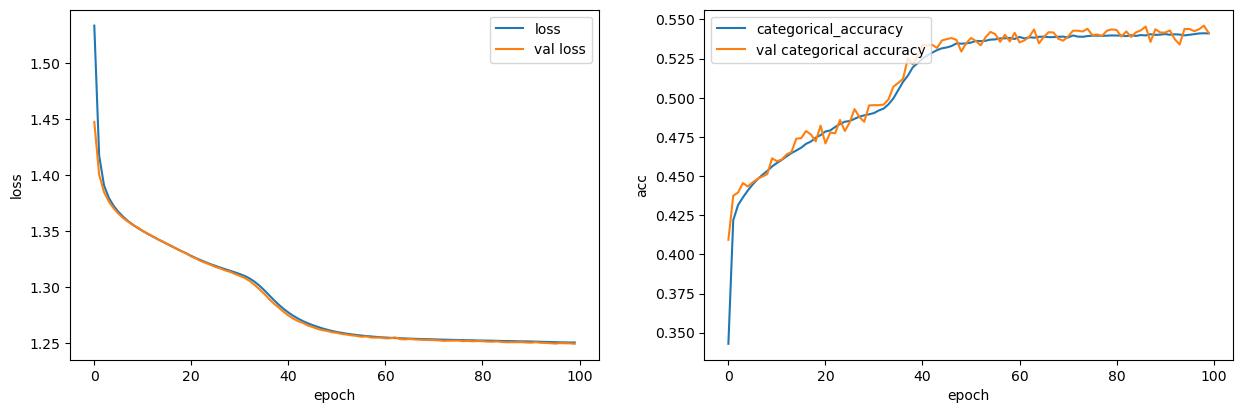

[I 2023-11-13 05:06:31,415] Trial 1 finished with value: 0.5433657765388489 and parameters: {'nlayers': 1, 'nhidden_l0': 27, 'learning_rate': 0.0001150481913265527, 'bsize': 32}. Best is trial 1 with value: 0.5433657765388489.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                2352      
                                                                 
 dense_1 (Dense)             (None, 11)                539       
                                                                 
 dense_2 (Dense)             (None, 5)                 60        
                                                                 
Total params: 2,951
Trainable params: 2,951
Non-trainable params: 0
_________________________________________________________________


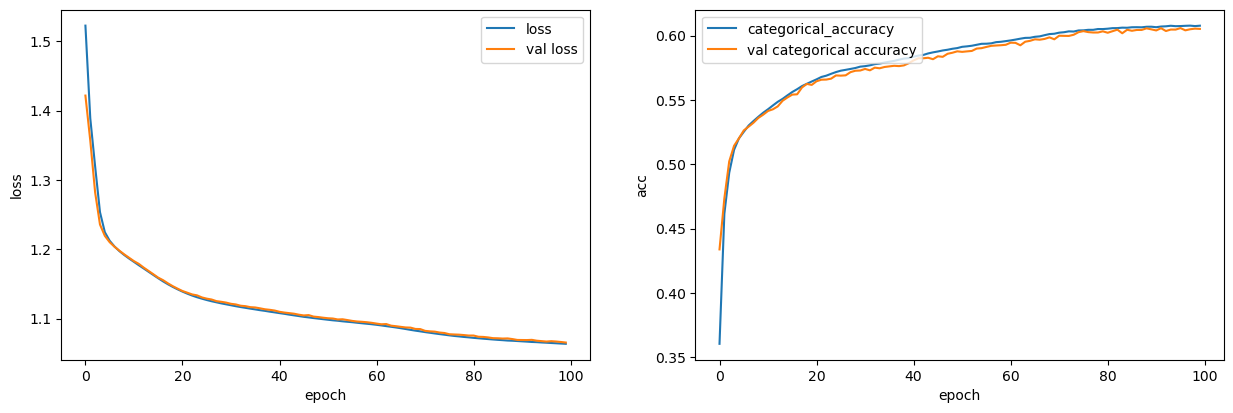

[I 2023-11-13 05:10:19,828] Trial 2 finished with value: 0.6056983470916748 and parameters: {'nlayers': 2, 'nhidden_l0': 48, 'nhidden_l1': 11, 'learning_rate': 0.00011240153621554707, 'bsize': 64}. Best is trial 2 with value: 0.6056983470916748.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 119)               5831      
                                                                 
 dense_1 (Dense)             (None, 5)                 600       
                                                                 
Total params: 6,431
Trainable params: 6,431
Non-trainable params: 0
_________________________________________________________________


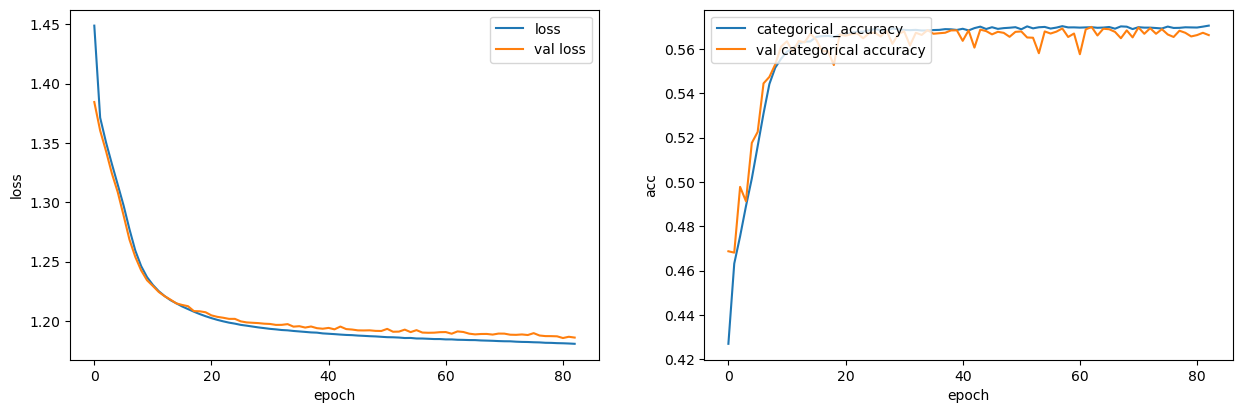

[I 2023-11-13 05:16:23,597] Trial 3 finished with value: 0.5700607299804688 and parameters: {'nlayers': 1, 'nhidden_l0': 119, 'learning_rate': 0.00018093446687807212, 'bsize': 32}. Best is trial 2 with value: 0.6056983470916748.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                1029      
                                                                 
 dense_1 (Dense)             (None, 42)                924       
                                                                 
 dense_2 (Dense)             (None, 48)                2064      
                                                                 
 dense_3 (Dense)             (None, 5)                 245       
                                                                 
Total params: 4,262
Trainable params: 4,262
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-13 05:17:13,994] Trial 4 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 57)                2793      
                                                                 
 dense_1 (Dense)             (None, 57)                3306      
                                                                 
 dense_2 (Dense)             (None, 47)                2726      
                                                                 
 dense_3 (Dense)             (None, 5)                 240       
                                                                 
Total params: 9,065
Trainable params: 9,065
Non-trainable params: 0
_________________________________________________________________


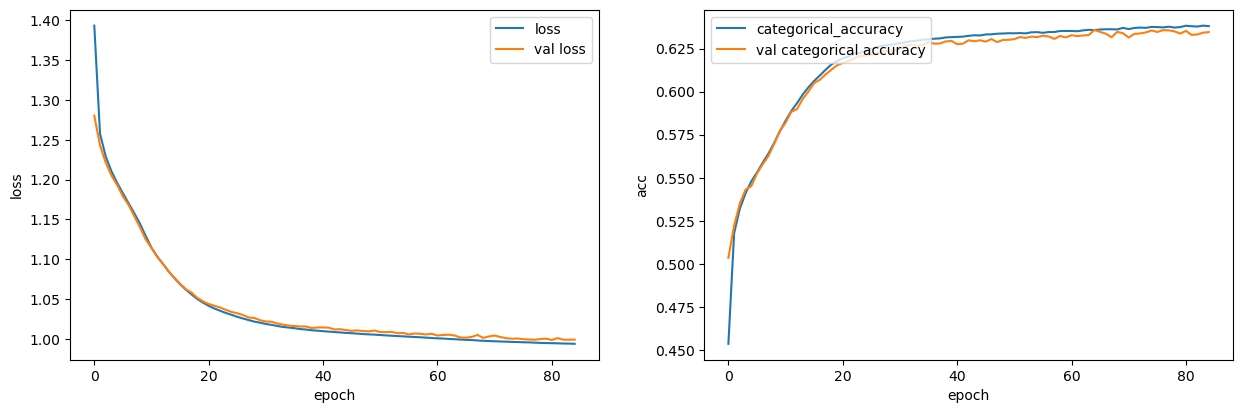

[I 2023-11-13 05:25:06,493] Trial 5 finished with value: 0.6334248185157776 and parameters: {'nlayers': 3, 'nhidden_l0': 57, 'nhidden_l1': 57, 'nhidden_l2': 47, 'learning_rate': 0.000135091219768504, 'bsize': 32}. Best is trial 5 with value: 0.6334248185157776.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                1960      
                                                                 
 dense_1 (Dense)             (None, 8)                 328       
                                                                 
 dense_2 (Dense)             (None, 11)                99        
                                                                 
 dense_3 (Dense)             (None, 5)                 60        
                                                                 
Total params: 2,447
Trainable params: 2,447
Non-trainable params: 0
_________________________________________________________________


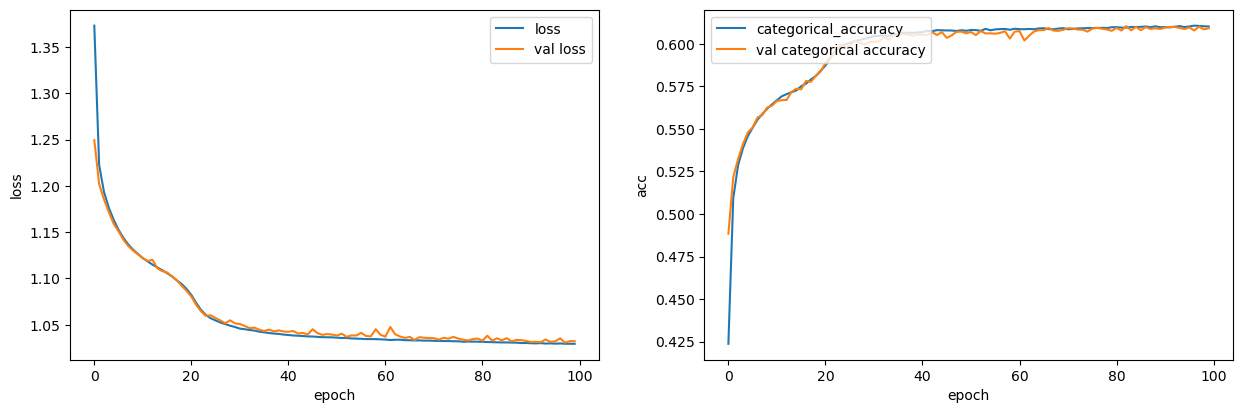

[I 2023-11-13 05:32:43,254] Trial 6 finished with value: 0.6071208715438843 and parameters: {'nlayers': 3, 'nhidden_l0': 40, 'nhidden_l1': 8, 'nhidden_l2': 11, 'learning_rate': 0.0002397691465172368, 'bsize': 32}. Best is trial 5 with value: 0.6334248185157776.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1470      
                                                                 
 dense_1 (Dense)             (None, 16)                496       
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
Total params: 2,051
Trainable params: 2,051
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-13 05:32:52,154] Trial 7 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                735       
                                                                 
 dense_1 (Dense)             (None, 9)                 144       
                                                                 
 dense_2 (Dense)             (None, 16)                160       
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,124
Trainable params: 1,124
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-13 05:33:10,378] Trial 8 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                2744      
                                                                 
 dense_1 (Dense)             (None, 81)                4617      
                                                                 
 dense_2 (Dense)             (None, 5)                 410       
                                                                 
Total params: 7,771
Trainable params: 7,771
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import util.util
import util.data
#from . import util as dsutil


'''
# Load data 
X_test = np.ascontiguousarray( np.load("{}/x_test_{}const.npy".format(datapath, nconst)) )
Y_test = np.load( "{}/y_test_{}const.npy".format(datapath, nconst), allow_pickle=True )
'''


util.util.device_info()
outdir = "./optuna"


kfolds = 5
val_kfold = 4

print("kfold numbet of folds:", kfolds )
print("val fold num:", val_kfold )

train_kfolds = [kfold for kfold in range(kfolds) if kfold != val_kfold]

fpath        =  f'./data_kfold/jets_{NCONSTIT}constituents_ptetaphi_nonorm'
fnames_train = [f'jet_images_c{NCONSTIT}_minpt2.0_ptetaphi_nonorm_{train_kfold}' for train_kfold in train_kfolds]
fname_val    =  f'jet_images_c{NCONSTIT}_minpt2.0_ptetaphi_nonorm_{val_kfold}'


data = util.data.Data.load_kfolds(fpath, fnames_train, fname_val)
print(data.train_data.shape)

X_train = data.train_data
X_val = data.test_data
X_test = data.test_data

Y_train = data.train_target
Y_val = data.test_target
Y_test = data.test_target

# normalization
interquantile_range_32 = [120, 0.27, 0.27]
interquantile_range_16 = [166, 0.24, 0.24]
interquantile_range_8  = [219, 0.20, 0.20]
    
if  NCONSTIT == 8:
    X_train     = X_train / interquantile_range_8
    X_val       = X_val   / interquantile_range_8
    X_test      = X_test  / interquantile_range_8
elif NCONSTIT == 16:
    X_train     = X_train / interquantile_range_16
    X_val       = X_val   / interquantile_range_16
    X_test      = X_test  / interquantile_range_16
elif NCONSTIT == 32:
    X_train     = X_train / interquantile_range_32
    X_val       = X_val   / interquantile_range_32
    X_test      = X_test  / interquantile_range_32
    
    
# Flatten data for MLP input
NINPUT = NCONSTIT * NFEAT
X_train = X_train.reshape(-1, NINPUT)
X_val  = X_val.reshape(-1, NINPUT)
X_test  = X_test.reshape(-1, NINPUT)
    
    
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)



# Set Optuna
study = optuna.create_study(
        study_name="mlp_study",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
        direction="maximize",
        storage="sqlite:///optuna_mlp_{}_constit.db".format(NCONSTIT),
        load_if_exists=True,
    )
        
    
    
# Optimize
study.optimize(objective, n_trials=NTRIALS, gc_after_trial=True)



## Print Optuna Results

In [ ]:

# Results

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



#trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
#trials = study.get_trials(deepcopy=False)
#print("Study statistics: ")
#print("  Number of finished trials: ", len(study.trials))
#print("  Number of trials: ", len(trials))

    
# reload study and continue optimizing
#study = optuna.load_study(study_name="example-study", storage="sqlite:///example.db")
#study.optimize(objective, n_trials=30)    



## MLP 32:
### BEST Trial ( MAXNEU: 128 )
###  Value:  0.6583895087242126
###  Params: 
###    nlayers: 4
###    nhidden_l0: 128
###    nhidden_l1: 59
###    nhidden_l2: 76
###    nhidden_l3: 9
###    learning_rate: 0.00043296719759933135
###    bsize: 64

## MLP 16 : 
##  BEST Trial 48 finished with value:0.655561089515686 and parameters: {'bsize': 64, 'nlayers': 3, 'nhidden_l0': 171, 'nhidden_l1': 30, 'nhidden_l2': 153, 'learning_rate': 0.00025664296269595563}.

## MLP 8:
## BEST Trial 47 finished with value: 0.6322103142738342 and parameters: {'bsize': 64, 'nlayers': 3, 'nhidden_l0': 152, 'nhidden_l1': 69, 'nhidden_l2': 63, 'learning_rate': 0.00023812077479493001}